In [1]:
import glob
import os
import pandas as pd, datetime
import numpy as np


In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [88]:
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
path = r'D:\data\full sale data in csv' # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)


C:\Users\House of Musa\AppData\Local\Temp\ipykernel_27820\2241175875.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
C:\Users\House of Musa\AppData\Local\Temp\ipykernel_27820\2241175875.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
C:\Users\House of Musa\AppData\Local\Temp\ipykernel_27820\2241175875.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
C:\Users\House of Musa\AppData\Local\Temp\ipykernel_27820\2241175875.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
C:\U

In [3]:
Exchange_rate = pd.read_csv(r'D:\data\sale in csv\Exchange_rate.csv')
Kolkata_temp = pd.read_csv(r'D:\Users\House of Musa\kol_temp.csv')

In [4]:
Exchange_rate['Date'] = pd.to_datetime(Exchange_rate['Date'], format = '%Y-%m-%d')
Exchange_rate
Kolkata_temp['time'] = pd.to_datetime(Kolkata_temp['time'], format = '%Y-%m-%d')
Kolkata_temp.tail()
Exchange_rate.head()

,Date,Price
0,2018-01-01,63.680
1,2018-01-02,63.460
2,2018-01-03,63.505
3,2018-01-04,63.400
4,2018-01-05,63.340


In [5]:
# splitting dataframe by Store location
# grouping by particular dataframe column
grouped = df.groupby(df.Store)
df1_CHOWRINGHEE = grouped.get_group("CITIMART - CHOWRINGHEE")
df1_NEWMARKET = grouped.get_group("CITIMART - NEW MARKET")
df1_HATIBAGAN = grouped.get_group("CITIMART - HATIBAGAN")
df1_GARIAHAT = grouped.get_group("CITIMART - GARIAHAT")

df_CHOWRINGHEE = df1_CHOWRINGHEE.loc[:, ['Bill_Date','SECTION','DIVISION' , 'RSP', 'Bill_Qty', 'Discount_Amt', 'Net_Amt']]
df_NEWMARKET = df1_NEWMARKET.loc[:, ['Bill_Date','SECTION', 'DIVISION' ,  'RSP', 'Bill_Qty', 'Discount_Amt', 'Net_Amt']]
df_HATIBAGAN = df1_HATIBAGAN.loc[:, ['Bill_Date','SECTION', 'DIVISION',  'RSP', 'Bill_Qty', 'Discount_Amt', 'Net_Amt']]
df_GARIAHAT = df1_GARIAHAT.loc[:, ['Bill_Date','SECTION', 'DIVISION',  'RSP', 'Bill_Qty', 'Discount_Amt', 'Net_Amt']]


In [6]:
df1 = df1_CHOWRINGHEE.loc[:, ['Bill_Date', 'RSP', 'Bill_Qty', 'Net_Amt']]

In [8]:
df1.shape

(780975, 4)

In [10]:
df1.describe()

,RSP,Bill_Qty,Net_Amt
count,780975.000000,780975.000000,780975.000000
mean,405.174665,1.108303,372.921312
std,372.474925,0.607422,385.312797
min,1.000000,-6.000000,-6889.000000
25%,129.000000,1.000000,100.000000
50%,299.000000,1.000000,299.000000
75%,599.000000,1.000000,549.000000
max,11999.000000,100.000000,11196.000000


In [11]:
df1['Bill_Date'] = pd.to_datetime(df1['Bill_Date'], format='%Y-%m-%d')

In [12]:
df1_sort = df1.sort_values('Bill_Date', ascending=True)
df1_sort.tail()

,Bill_Date,RSP,Bill_Qty,Net_Amt
1907854,2024-04-30,599.0,1.0,599.0
1907855,2024-04-30,199.0,1.0,199.0
1907856,2024-04-30,199.0,2.0,398.0
1907858,2024-04-30,199.0,2.0,398.0
1908010,2024-04-30,51.0,1.0,45.9


In [47]:
df_a = df1_sort.groupby('Bill_Date').agg(Total_Qty=('Bill_Qty', 'sum'),
                            RSP_AVG=('RSP', 'mean'),
                            Net_Amt=('Net_Amt', 'sum')).reset_index().rename(columns={'Bill_Date': 'Bill_Date'})
df_a

,Bill_Date,Total_Qty,RSP_AVG,Net_Amt
0,2020-01-01,717.0,508.746318,286810.24
1,2020-01-02,542.0,505.220374,219617.99
2,2020-01-03,318.0,490.132841,134004.28
3,2020-01-04,558.0,490.962422,216566.59
4,2020-01-05,754.0,481.954819,287944.09
...,...,...,...,...
1484,2024-04-26,770.0,329.820442,236707.80
1485,2024-04-27,912.0,331.444444,265928.70
1486,2024-04-28,1156.0,359.304432,370048.70
1487,2024-04-29,404.0,330.712251,117375.55


In [48]:
df_f = df_a.loc[:, [ 'Bill_Date', 'Net_Amt', 'Total_Qty', 'RSP_AVG']]

In [50]:
df_f.head()

,Bill_Date,Net_Amt,Total_Qty,RSP_AVG
0,2020-01-01,286810.24,717.0,508.746318
1,2020-01-02,219617.99,542.0,505.220374
2,2020-01-03,134004.28,318.0,490.132841
3,2020-01-04,216566.59,558.0,490.962422
4,2020-01-05,287944.09,754.0,481.954819


In [51]:
df_f.index = pd.to_datetime(df_f.Bill_Date)
df_f

,Bill_Date,Net_Amt,Total_Qty,RSP_AVG
Bill_Date,,,,
2020-01-01,2020-01-01,286810.24,717.0,508.746318
2020-01-02,2020-01-02,219617.99,542.0,505.220374
2020-01-03,2020-01-03,134004.28,318.0,490.132841
2020-01-04,2020-01-04,216566.59,558.0,490.962422
2020-01-05,2020-01-05,287944.09,754.0,481.954819
...,...,...,...,...
2024-04-26,2024-04-26,236707.80,770.0,329.820442
2024-04-27,2024-04-27,265928.70,912.0,331.444444
2024-04-28,2024-04-28,370048.70,1156.0,359.304432


In [52]:
df_daily = df_f.resample('D').agg({"Net_Amt":'sum',"Total_Qty":'sum',"RSP_AVG":'mean'})

In [53]:
df_monthly = df_daily.resample('M').agg({"Net_Amt":'sum',"Total_Qty":'sum',"RSP_AVG":'mean'})

In [54]:
df_daily.head()

,Net_Amt,Total_Qty,RSP_AVG
Bill_Date,,,
2020-01-01,286810.24,717.0,508.746318
2020-01-02,219617.99,542.0,505.220374
2020-01-03,134004.28,318.0,490.132841
2020-01-04,216566.59,558.0,490.962422
2020-01-05,287944.09,754.0,481.954819


In [26]:
# Creating a train dataset
ddf = df_daily.copy()
ddf.reset_index(level=0, inplace=True)

In [28]:
ddf.head()

,Bill_Date,Net_Amt,Total_Qty,RSP_AVG
0,2020-01-01,286810.24,717.0,508.746318
1,2020-01-02,219617.99,542.0,505.220374
2,2020-01-03,134004.28,318.0,490.132841
3,2020-01-04,216566.59,558.0,490.962422
4,2020-01-05,287944.09,754.0,481.954819


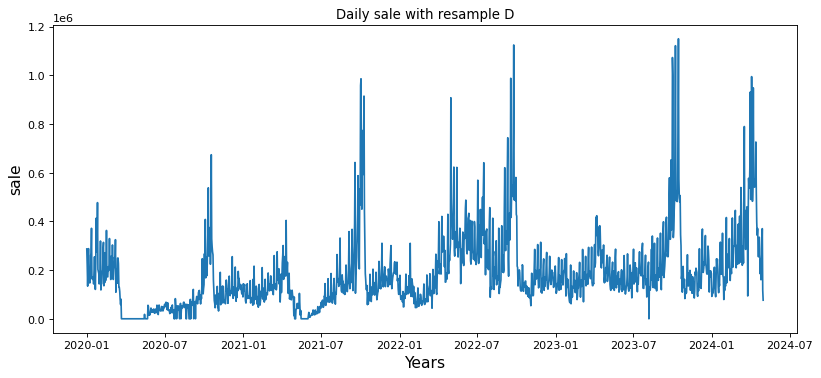

In [55]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
figure(figsize=(12, 5), dpi=80, linewidth=10)
plt.plot(ddf['Bill_Date'], ddf['Net_Amt'])
plt.title('Daily sale with resample D')
plt.xlabel('Years', fontsize=14)
plt.ylabel('sale', fontsize=14)
plt.show()

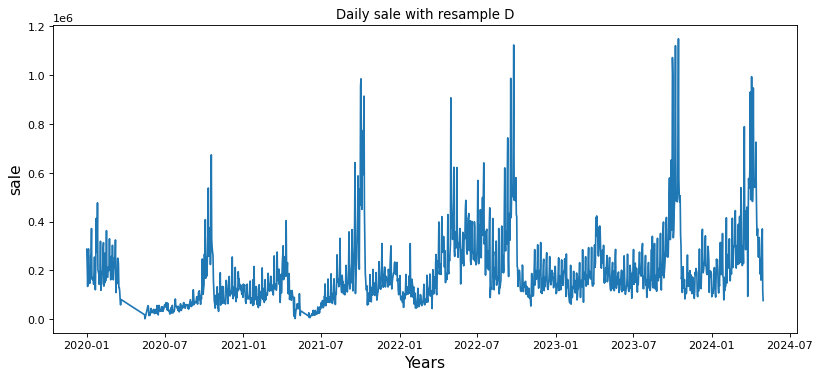

In [56]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
figure(figsize=(12, 5), dpi=80, linewidth=10)
plt.plot(df_a['Bill_Date'], df_a['Net_Amt'])
plt.title('Daily sale with resample D')
plt.xlabel('Years', fontsize=14)
plt.ylabel('sale', fontsize=14)
plt.show()

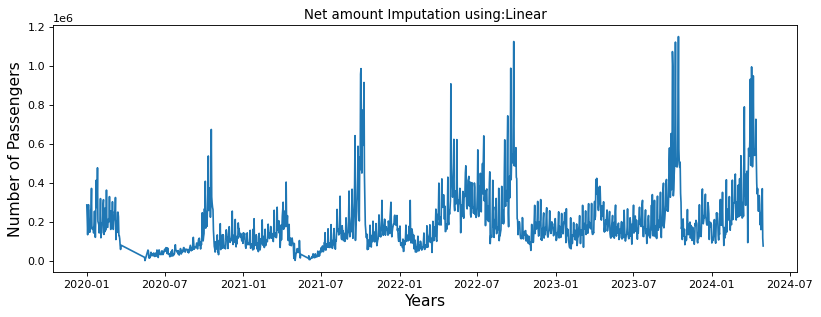

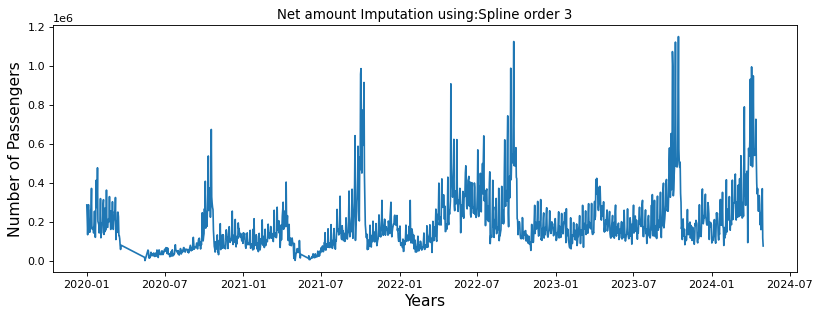

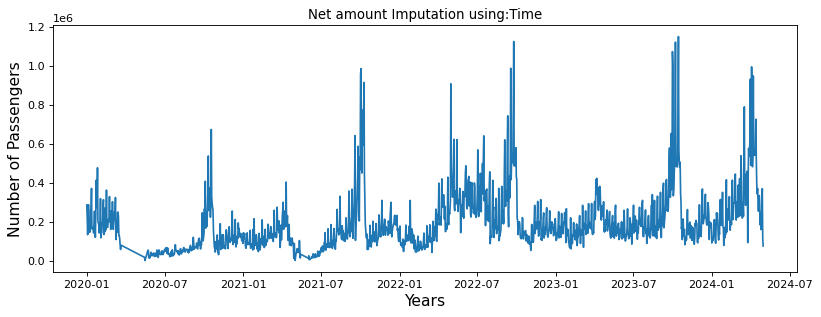

In [57]:
#Missing Value Imputation in Time Series(on indexed dataset)
#Time-Based Interpolation
#Spline Interpolation
#Linear Interpolation

df_f['Linear'] = df_f['Net_Amt'].interpolate(method='linear')
df_f['Spline order 3'] = df_f['Net_Amt'].interpolate(method='spline', order=3)
df_f['Time'] = df_f['Net_Amt'].interpolate(method='time')
methods = ['Linear', 'Spline order 3', 'Time']
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
for method in methods:
    figure(figsize=(12, 4), dpi=80, linewidth=10)
    plt.plot(df_f["Bill_Date"], df_f[method])
    plt.title("Net amount Imputation using:" + method)
    plt.xlabel("Years", fontsize=14)
    plt.ylabel("Number of Passengers", fontsize=14)
    plt.show()

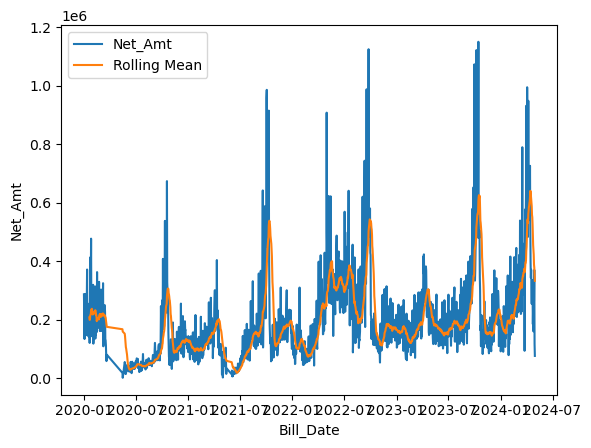

In [58]:
#Denoising a Time Series
#Rolling means
rolling_google = df_f['Linear'].rolling(20).mean()
plt.plot(df_f['Bill_Date'], df_f['Linear'])
plt.plot(df_f['Bill_Date'], rolling_google)
plt.xlabel('Bill_Date')
plt.ylabel('Net_Amt')
plt.legend(['Net_Amt','Rolling Mean'])
plt.show()

In [61]:
#df_f.reset_index(level=0, inplace=True)
#df_f
train_prophet = df_f.loc[:,[ 'Net_Amt', 'Total_Qty', 'RSP_AVG']]

In [66]:
train_prophet.reset_index(level=0, inplace=True)

In [67]:
train_prophet.head()

,Bill_Date,y,Total_Qty,RSP_AVG
0,2020-01-01,286810.24,717.0,508.746318
1,2020-01-02,219617.99,542.0,505.220374
2,2020-01-03,134004.28,318.0,490.132841
3,2020-01-04,216566.59,558.0,490.962422
4,2020-01-05,287944.09,754.0,481.954819


In [68]:
train_prophet = train_prophet.rename(columns = {'Bill_Date': 'ds', 'Net_Amt': 'y'})

In [69]:
# Handle missing values
train_prophet.fillna(method='ffill', inplace=True)

In [70]:
train_prophet.head()

,ds,y,Total_Qty,RSP_AVG
0,2020-01-01,286810.24,717.0,508.746318
1,2020-01-02,219617.99,542.0,505.220374
2,2020-01-03,134004.28,318.0,490.132841
3,2020-01-04,216566.59,558.0,490.962422
4,2020-01-05,287944.09,754.0,481.954819


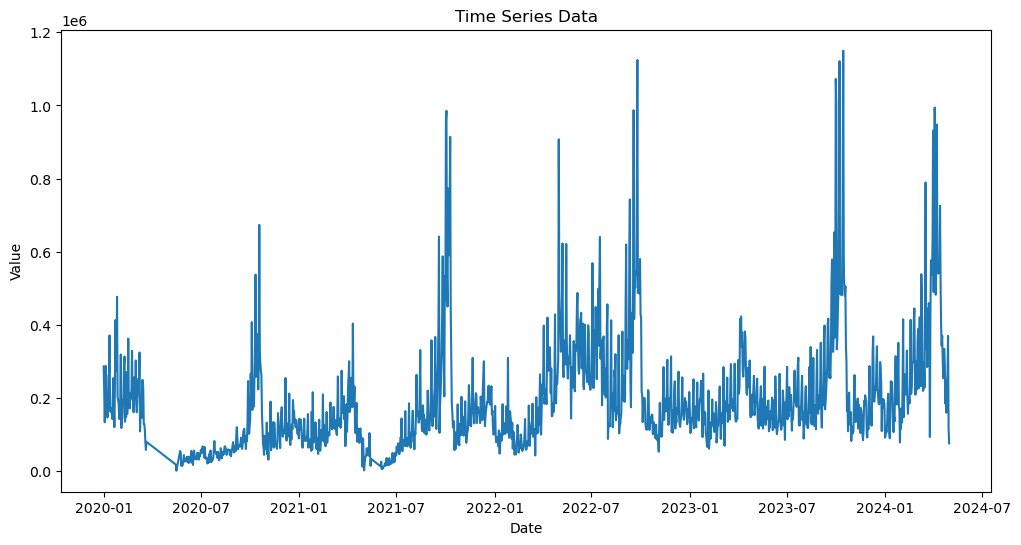

In [71]:
#Outliers visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_prophet['ds'], train_prophet['y'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()

In [72]:
#Statistical Methods:
#Use statistical methods such as the IQR (Interquartile Range) method or Z-score to detect outliers.

#import numpy as np

Q1 = train_prophet['y'].quantile(0.25)
Q3 = train_prophet['y'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = train_prophet[(train_prophet['y'] < (Q1 - 1.5 * IQR)) | (train_prophet['y'] > (Q3 + 1.5 * IQR))]

# Remove outliers
df_clean1 = train_prophet[~train_prophet.index.isin(outliers.index)]

In [74]:
#Using Z-score:

from scipy import stats

z_scores = np.abs(stats.zscore(train_prophet['y']))
outliers = train_prophet[z_scores > 3]

# Remove outliers
df_clean2 = train_prophet[z_scores <= 3]

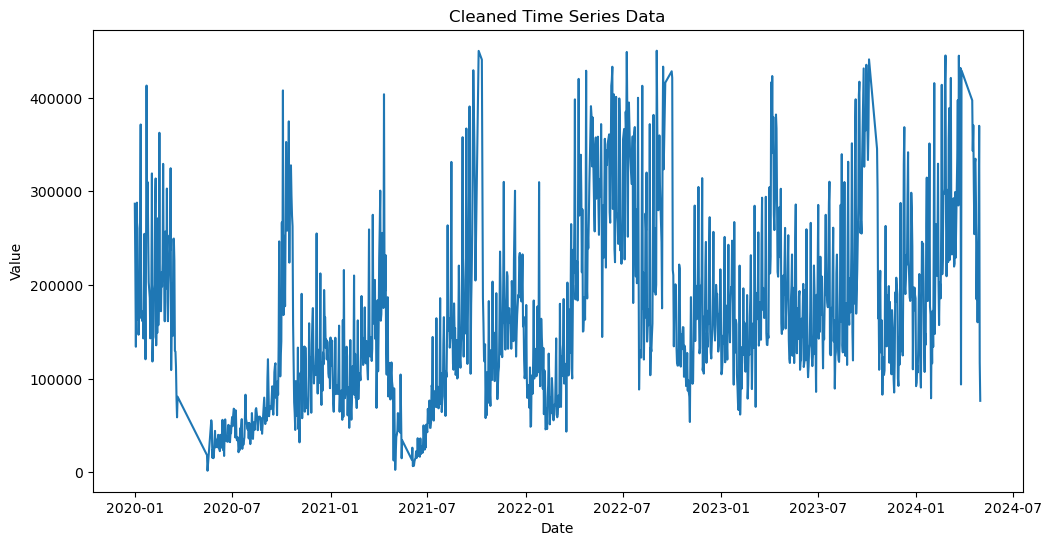

In [75]:
#Replot Cleaned Data:
plt.figure(figsize=(12, 6))
plt.plot(df_clean1['ds'], df_clean1['y'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Cleaned Time Series Data')
plt.show()

In [79]:
# Initialize scalers
scaler_y = MinMaxScaler()
scaler_features = MinMaxScaler()

# Fit and transform y
df_clean1['y'] = scaler_y.fit_transform(df_clean1[['y']])

# Fit and transform features
df_clean1[['Total_Qty', 'RSP_AVG']] = scaler_features.fit_transform(df_clean1[['Total_Qty', 'RSP_AVG']])

# Debug: Ensure 'ds' column is present after normalization
print(df_clean1.columns)

Index(['ds', 'y', 'Total_Qty', 'RSP_AVG'], dtype='object')


C:\Users\House of Musa\AppData\Local\Temp\ipykernel_27820\52546886.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean1['y'] = scaler_y.fit_transform(df_clean1[['y']])
C:\Users\House of Musa\AppData\Local\Temp\ipykernel_27820\52546886.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean1[['Total_Qty', 'RSP_AVG']] = scaler_features.fit_transform(df_clean1[['Total_Qty', 'RSP_AVG']])


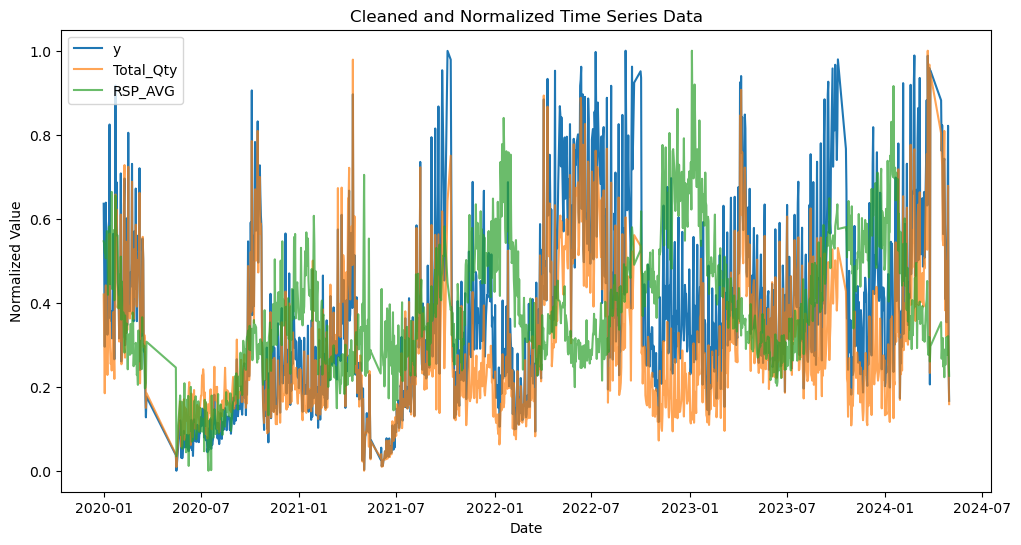

In [80]:
# Visual inspection of cleaned and normalized data
plt.figure(figsize=(12, 6))
plt.plot(df_clean1['ds'], df_clean1['y'], label='y')
plt.plot(df_clean1['ds'], df_clean1['Total_Qty'], label='Total_Qty', alpha=0.7)
plt.plot(df_clean1['ds'], df_clean1['RSP_AVG'], label='RSP_AVG', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.title('Cleaned and Normalized Time Series Data')
plt.legend()
plt.show()

In [81]:
# Example of adding a holiday effect
holidays = pd.DataFrame({
    'holiday': 'holiday_name',
    'ds': pd.to_datetime(['2020-01-01', '2024-05-31']),
    'lower_window': 0,
    'upper_window': 1,
})

In [82]:
# Split the data into train, validation, and test sets
train_size = 0.7
validation_size = 0.2
test_size = 0.1

In [83]:
train_end = int(len(df_clean1) * train_size)
validation_end = int(len(df_clean1) * (train_size + validation_size))

train_df = df_clean1[:train_end]
validation_df = df_clean1[train_end:validation_end]
test_df = df_clean1[validation_end:]

In [84]:
# Fit and transform y
train_df['y'] = scaler_y.fit_transform(train_df[['y']])
validation_df['y'] = scaler_y.transform(validation_df[['y']])
test_df['y'] = scaler_y.transform(test_df[['y']])

C:\Users\House of Musa\AppData\Local\Temp\ipykernel_27820\3397052283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['y'] = scaler_y.fit_transform(train_df[['y']])
C:\Users\House of Musa\AppData\Local\Temp\ipykernel_27820\3397052283.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df['y'] = scaler_y.transform(validation_df[['y']])
C:\Users\House of Musa\AppData\Local\Temp\ipykernel_27820\3397052283.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [85]:
# Fit and transform features
train_df[['Total_Qty', 'RSP_AVG']] = scaler_features.fit_transform(train_df[['Total_Qty', 'RSP_AVG']])
validation_df[['Total_Qty', 'RSP_AVG']] = scaler_features.transform(validation_df[['Total_Qty', 'RSP_AVG']])
test_df[['Total_Qty', 'RSP_AVG']] = scaler_features.transform(test_df[['Total_Qty', 'RSP_AVG']])


C:\Users\House of Musa\AppData\Local\Temp\ipykernel_27820\4001869641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[['Total_Qty', 'RSP_AVG']] = scaler_features.fit_transform(train_df[['Total_Qty', 'RSP_AVG']])
C:\Users\House of Musa\AppData\Local\Temp\ipykernel_27820\4001869641.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df[['Total_Qty', 'RSP_AVG']] = scaler_features.transform(validation_df[['Total_Qty', 'RSP_AVG']])
C:\Users\House of Musa\AppData\Local\Temp\ipykernel_27820\

In [86]:
# Debug: Ensure 'ds' column is present after normalization
print(train_df.columns)
print(validation_df.columns)
print(test_df.columns)


Index(['ds', 'y', 'Total_Qty', 'RSP_AVG'], dtype='object')
Index(['ds', 'y', 'Total_Qty', 'RSP_AVG'], dtype='object')
Index(['ds', 'y', 'Total_Qty', 'RSP_AVG'], dtype='object')


In [89]:
model = Prophet(holidays=holidays)
model.add_country_holidays(country_name='IN')
model.add_regressor('Total_Qty')
model.add_regressor('RSP_AVG')
model.fit(train_df[['ds', 'y', 'Total_Qty', 'RSP_AVG']])


D:\Users\House of Musa\anaconda3\Lib\site-packages\holidays\countries\india.py:100: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
18:01:52 - cmdstanpy - INFO - Chain [1] start processing
18:01:52 - cmdstanpy - INFO - Chain [1] done processing


In [90]:
# Validate the model
validation_future = validation_df[['ds', 'Total_Qty', 'RSP_AVG']].copy()
validation_forecast = model.predict(validation_future)
validation_rmse = mean_squared_error(validation_df['y'], validation_forecast['yhat'], squared=False)
print(f'Validation RMSE: {validation_rmse}')


Validation RMSE: 0.06558103552714124


In [91]:
# Test the model
test_future = test_df[['ds', 'Total_Qty', 'RSP_AVG']].copy()
test_forecast = model.predict(test_future)
test_rmse = mean_squared_error(test_df['y'], test_forecast['yhat'], squared=False)
print(f'Test RMSE: {test_rmse}')


Test RMSE: 0.08833513969752611


In [92]:
# Create a future DataFrame for forecasting
future_periods = 365  # Number of days into the future you want to predict
future = model.make_future_dataframe(periods=future_periods)

In [93]:
# Assume you have future values for 'Total_Qty' and 'RSP_AVG'
# For demonstration, we'll use random values. Replace with actual future values.
future_total_qty = np.random.normal(70, 5, size=(len(future),))
future_rsp_avg = np.random.normal(30, 5, size=(len(future),))

future['Total_Qty'] = future_total_qty
future['RSP_AVG'] = future_rsp_avg


In [94]:
# Normalize the future regressors similarly using the already fitted scaler
future[['Total_Qty', 'RSP_AVG']] = scaler_features.transform(future[['Total_Qty', 'RSP_AVG']])


In [95]:
# Make predictions
forecast = model.predict(future)


In [96]:
# Inverse transform yhat to get it back to the original scale
forecast['yhat'] = scaler_y.inverse_transform(forecast[['yhat']])


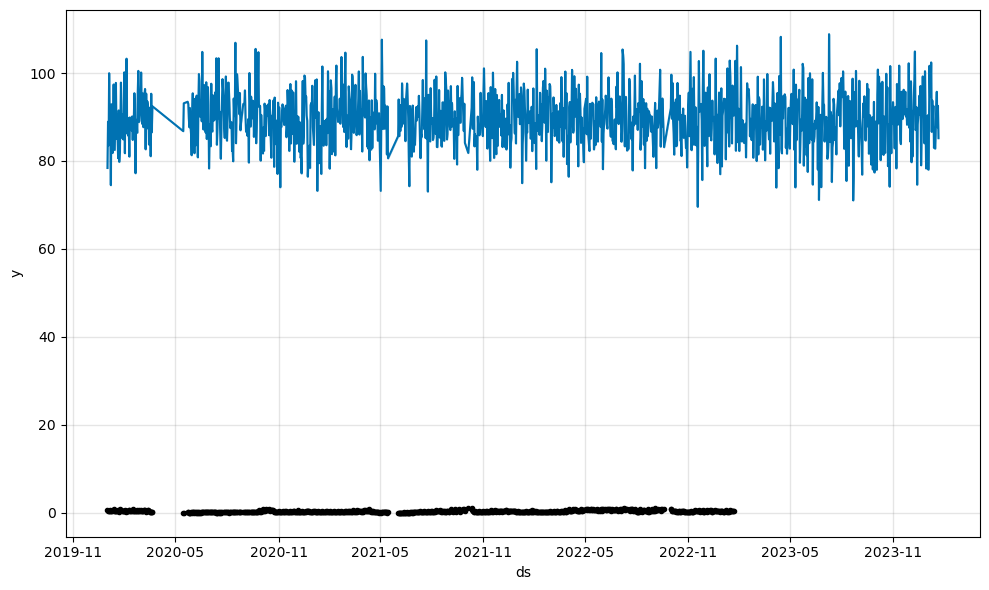

In [97]:
# Plot the forecast
fig = model.plot(forecast)
plt.show()


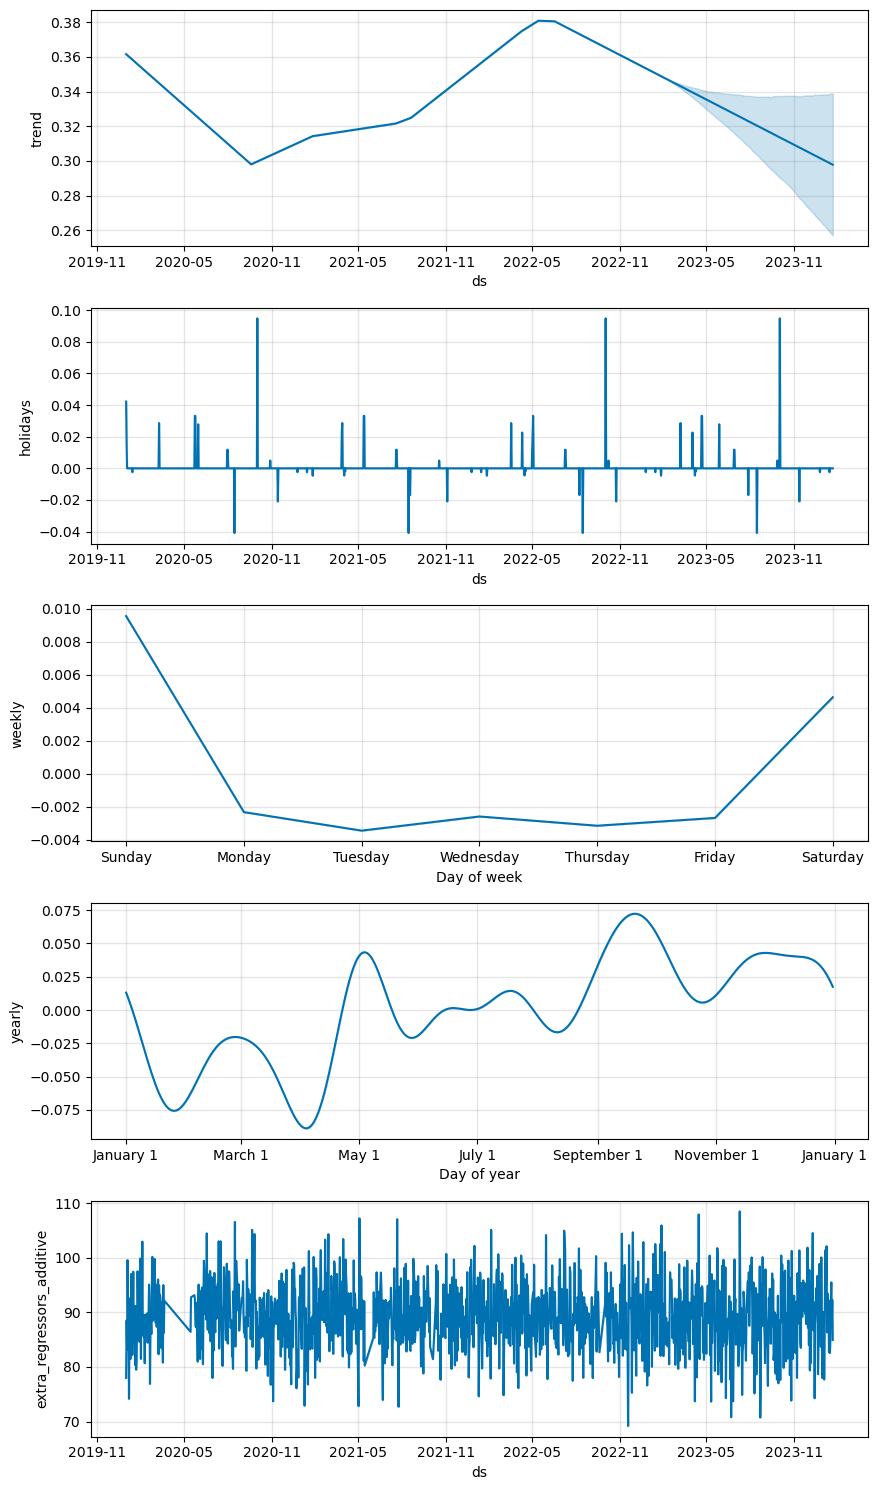

In [98]:
# Plot components
fig_components = model.plot_components(forecast)
plt.show()